<a href="https://colab.research.google.com/github/prasannakumarnalabolu-beep/traffics-/blob/main/Deep_Learning_Based_Intelligent_Traffic_Signal_Control_System_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical

import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#  Load & Explore Dataset

In [ ]:
df = pd.read_csv("/content/smart_traffic_management_dataset.csv")

print("Shape:", df.shape)
df.head()

Shape: (2000, 12)


,timestamp,location_id,traffic_volume,avg_vehicle_speed,vehicle_count_cars,vehicle_count_trucks,vehicle_count_bikes,weather_condition,temperature,humidity,accident_reported,signal_status
0,2024-01-01 00:00:00,4,504,53.124162,142,24,44,Cloudy,33.334387,36.390698,0,Red
1,2024-01-01 00:01:00,5,209,44.947850,862,50,23,Cloudy,17.926830,37.640927,0,Green
2,2024-01-01 00:02:00,3,572,63.179229,317,12,10,Windy,33.483375,84.262610,1,Red
3,2024-01-01 00:03:00,5,699,42.269697,709,43,21,Sunny,19.212941,61.550978,0,Yellow
4,2024-01-01 00:04:00,5,639,72.185791,594,34,14,Cloudy,11.349244,77.494506,0,Red


#  Exploratory Data Analysis (EDA)

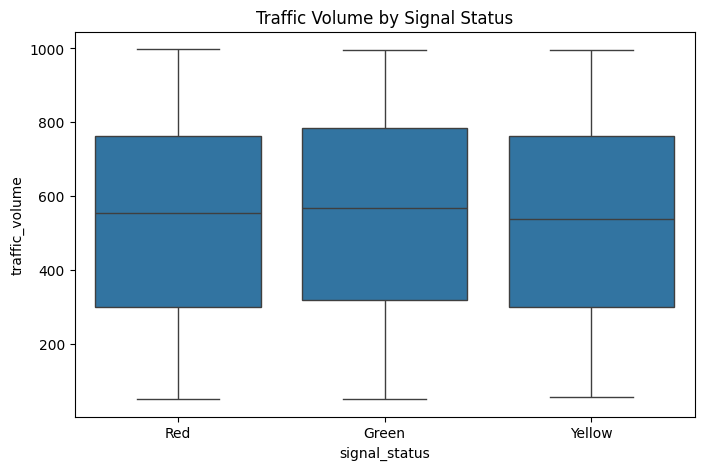

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='signal_status', y='traffic_volume', data=df)
plt.title("Traffic Volume by Signal Status")
plt.show()

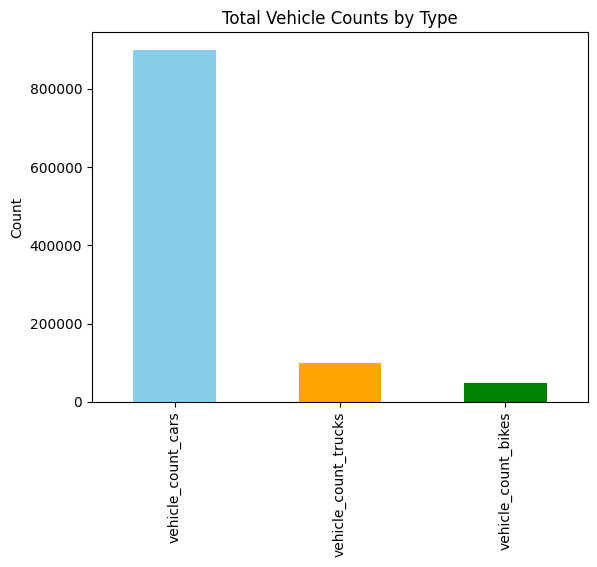

In [ ]:
vehicle_counts = df[['vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes']].sum()
vehicle_counts.plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("Total Vehicle Counts by Type")
plt.ylabel("Count")
plt.show()

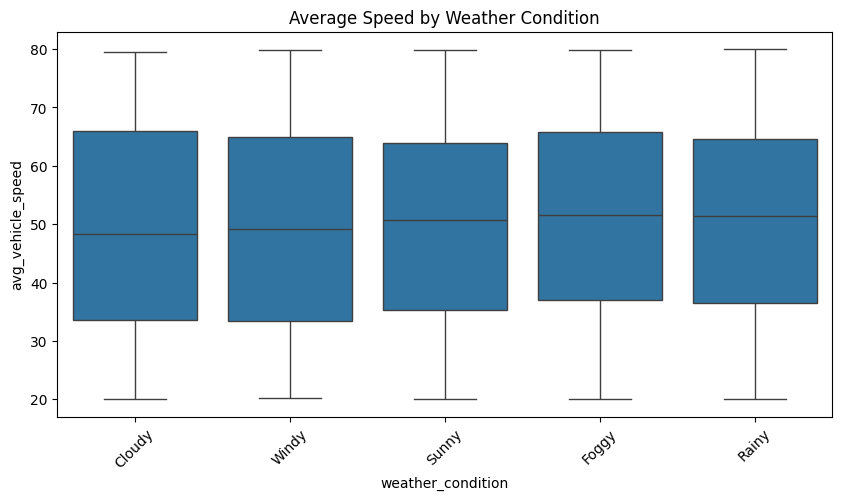

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weather_condition', y='avg_vehicle_speed', data=df)
plt.title("Average Speed by Weather Condition")
plt.xticks(rotation=45)
plt.show()

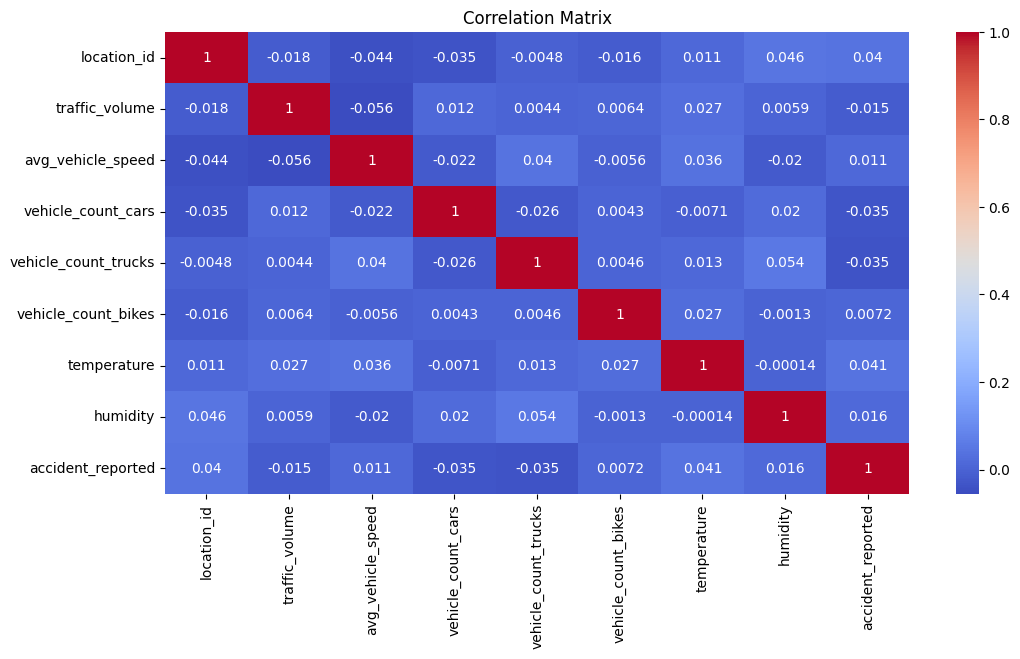

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Data Preprocessing

In [ ]:
df.dropna(inplace=True)

le_weather = LabelEncoder()
df['weather_condition'] = le_weather.fit_transform(df['weather_condition'])

In [ ]:
le_signal = LabelEncoder()
df['signal_status_encoded'] = le_signal.fit_transform(df['signal_status'])

X = df.drop(['signal_status', 'signal_status_encoded'], axis=1)
y = df['signal_status_encoded']

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.drop('timestamp', axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LSTM Model

In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,379 (83.51 KB)

 Trainable params: 21,379 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3239 - loss: 1.0996 - val_accuracy: 0.4125 - val_loss: 1.0908
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3614 - loss: 1.0964 - val_accuracy: 0.3550 - val_loss: 1.0937
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3721 - loss: 1.0944 - val_accuracy: 0.3175 - val_loss: 1.0967
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3676 - loss: 1.0936 - val_accuracy: 0.3825 - val_loss: 1.0930
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3595 - loss: 1.0932 - val_accuracy: 0.3625 - val_loss: 1.0953
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3426 - loss: 1.0968 - val_accuracy: 0.4025 - val_loss: 1.0897
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3737 - loss: 1.0938 - val_accuracy: 0.3800 - val_loss: 1.0936
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3639 - loss: 1.0945 - val_accuracy: 0.3800 - val_loss

## Evaluate LSTM

In [ ]:
lstm_preds = lstm_model.predict(X_test_lstm)
lstm_y_pred = np.argmax(lstm_preds, axis=1)

print("LSTM Accuracy:", accuracy_score(y_test, lstm_y_pred))
print("\nLSTM Report:\n", classification_report(y_test, lstm_y_pred, target_names=le_signal.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Accuracy: 0.3875

LSTM Report:
               precision    recall  f1-score   support

       Green       0.29      0.17      0.21       108
         Red       0.38      0.35      0.36       135
      Yellow       0.42      0.57      0.49       157

    accuracy                           0.39       400
   macro avg       0.36      0.36      0.35       400
weighted avg       0.37      0.39      0.37       400



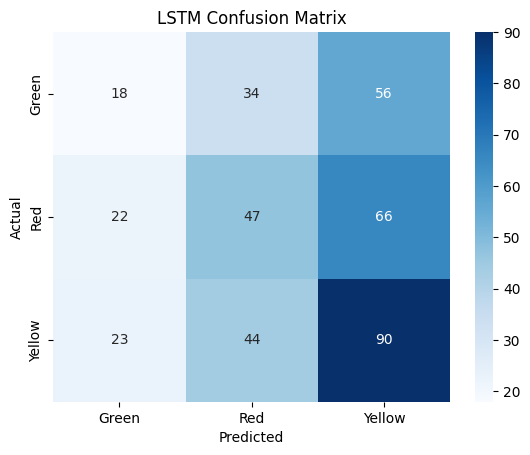

In [ ]:
sns.heatmap(confusion_matrix(y_test, lstm_y_pred), annot=True, cmap="Blues",
            xticklabels=le_signal.classes_, yticklabels=le_signal.classes_)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# CNN Model

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,371 (9.26 KB)

 Trainable params: 2,371 (9.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3619 - loss: 1.0968 - val_accuracy: 0.3300 - val_loss: 1.0983
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3059 - loss: 1.1011 - val_accuracy: 0.3900 - val_loss: 1.0925
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3359 - loss: 1.1019 - val_accuracy: 0.3275 - val_loss: 1.0939
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3714 - loss: 1.0956 - val_accuracy: 0.3925 - val_loss: 1.0910
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3251 - loss: 1.1017 - val_accuracy: 0.3850 - val_loss: 1.0919
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3253 - loss: 1.0998 - val_accuracy: 0.3875 - val_loss: 1.0934
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3460 - loss: 1.0996 - val_accuracy: 0.3275 - val_loss: 1.0940
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3509 - loss: 1.0982 - val_accuracy: 0.3925 - val_loss

## Evaluate CNN

In [ ]:
cnn_preds = cnn_model.predict(X_test_cnn)
cnn_y_pred = np.argmax(cnn_preds, axis=1)

print("CNN Accuracy:", accuracy_score(y_test, cnn_y_pred))
print("\nCNN Report:\n", classification_report(y_test, cnn_y_pred, target_names=le_signal.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN Accuracy: 0.37

CNN Report:
               precision    recall  f1-score   support

       Green       0.34      0.12      0.18       108
         Red       0.32      0.39      0.35       135
      Yellow       0.41      0.53      0.46       157

    accuracy                           0.37       400
   macro avg       0.36      0.34      0.33       400
weighted avg       0.36      0.37      0.35       400



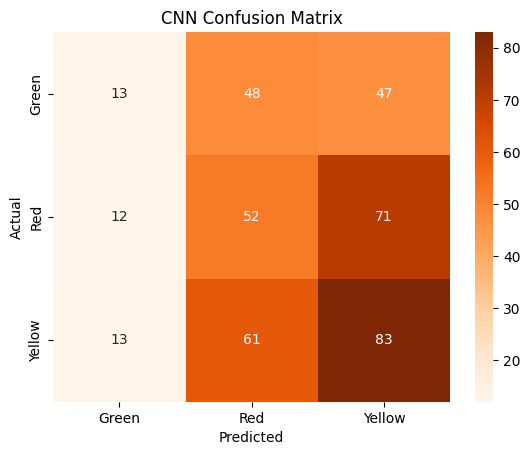

In [ ]:
sns.heatmap(confusion_matrix(y_test, cnn_y_pred), annot=True, cmap="Oranges",
            xticklabels=le_signal.classes_, yticklabels=le_signal.classes_)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# DQL Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size      # 4 input features
        self.action_size = action_size    # 3 possible actions
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95     # discount rate
        self.epsilon = 1.0    # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))  # Q-values output
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # explore
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # exploit

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Simulate on 10 sample scenarios
simulation_df = df.sample(10).copy()

features = ['traffic_volume', 'avg_vehicle_speed', 'weather_condition', 'accident_reported']
X = simulation_df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

states = np.array([x.reshape(1, -1) for x in X_scaled])

In [ ]:
agent = DQNAgent(state_size=4, action_size=3)

episodes = 10
for e in range(episodes):
    for i in range(len(states)):
        state = states[i]
        action = agent.act(state)

        # Dummy reward mechanism: reward "Go" on low traffic, penalize on accident
        reward = 1
        if X.iloc[i]['accident_reported'] == 1 and action == 0:  # went during accident
            reward = -1
        elif X.iloc[i]['traffic_volume'] > 0.8 and action == 0:
            reward = -0.5  # risky "Go"
        next_state = state  # no transition in offline data
        done = True  # one-step environment
        agent.remember(state, action, reward, next_state, done)

    agent.replay(batch_size=32)
    print(f"Episode {e+1}/{episodes}, Epsilon: {agent.epsilon:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/10, Epsilon: 0.99
Episode 2/10, Epsilon: 0.99
Episode 3/10, Epsilon: 0.99
Episode 4/10, Epsilon: 0.98
Episode 5/10, Epsilon: 0.98
Episode 6/10, Epsilon: 0.97
Episode 7/10, Epsilon: 0.97
Episode 8/10, Epsilon: 0.96
Episode 9/10, Epsilon: 0.96
Episode 10/10, Epsilon: 0.95


In [ ]:
# Simulate on 10 sample scenarios
simulation_df_ann = df.sample(10).copy()
features = ['traffic_volume', 'avg_vehicle_speed', 'weather_condition', 'accident_reported']
X_sim_ann = simulation_df_ann[features]
scaler_sim_ann = MinMaxScaler()
X_scaled_sim_ann = scaler_sim_ann.fit_transform(X_sim_ann)

predicted_actions = []
for state in X_scaled_sim_ann:
    # Reshape state for the DQL agent's model prediction
    state_reshaped = state.reshape(1, -1)
    action = agent.act(state_reshaped)
    predicted_actions.append(action)

simulation_df_ann['dql_signal_status'] = predicted_actions

In [ ]:
signal_map = {0: 'Go', 1: 'Stop', 2: 'Caution'}
simulation_df_ann['dql_signal_status'] = simulation_df_ann['dql_signal_status'].map(signal_map)

In [ ]:
print("DQL-based Signal Decisions:")
(simulation_df_ann[['location_id', 'traffic_volume', 'avg_vehicle_speed',
                         'weather_condition', 'accident_reported', 'dql_signal_status']])


DQL-based Signal Decisions:


,location_id,traffic_volume,avg_vehicle_speed,weather_condition,accident_reported,dql_signal_status
1979,3,342,46.724571,3,0,Caution
720,3,449,47.691376,3,0,Caution
722,2,554,67.202500,0,0,Go
1915,5,137,44.975767,0,0,Stop
264,4,239,73.762448,3,0,Go
1458,1,406,70.389221,2,0,Go
667,1,237,45.564259,0,0,Go
1258,3,487,61.801707,3,0,Stop
403,5,434,75.531332,3,0,Caution
670,3,866,41.012179,4,0,Go


# Simulate real-time traffic for LSTM


In [ ]:
simulation_df_lstm = df.sample(10).copy()


features_for_model = [
    'location_id', 'traffic_volume', 'avg_vehicle_speed',
    'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes',
    'weather_condition', 'temperature', 'humidity', 'accident_reported'
]

sim_features_lstm = simulation_df_lstm[features_for_model]

# Fit a new scaler specifically for the LSTM and CNN models
scaler_lstm_cnn = MinMaxScaler()
sim_lstm_scaled = scaler_lstm_cnn.fit_transform(sim_features_lstm)

sim_lstm_reshaped = sim_lstm_scaled.reshape(sim_lstm_scaled.shape[0], 1, sim_lstm_scaled.shape[1])

lstm_sim_preds = lstm_model.predict(sim_lstm_reshaped)
lstm_sim_classes = np.argmax(lstm_sim_preds, axis=1)
lstm_signal_labels = le_signal.inverse_transform(lstm_sim_classes)

simulation_df_lstm['predicted_signal_status'] = lstm_signal_labels

print("--- LSTM-based Simulated Adaptive Signal Decisions: ---")
display(simulation_df_lstm[['location_id', 'traffic_volume', 'avg_vehicle_speed', 'accident_reported', 'signal_status', 'predicted_signal_status']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--- LSTM-based Simulated Adaptive Signal Decisions: ---


,location_id,traffic_volume,avg_vehicle_speed,accident_reported,signal_status,predicted_signal_status
1527,2,444,55.538082,0,Red,Red
1200,2,869,58.894154,0,Green,Green
219,1,128,69.389650,0,Green,Yellow
892,2,637,69.758854,0,Green,Yellow
1264,1,708,46.434412,0,Green,Red
398,4,894,52.976376,0,Yellow,Yellow
1623,1,548,29.752279,0,Yellow,Red
1656,2,140,60.709470,0,Yellow,Red
707,3,309,51.995084,0,Yellow,Yellow
1253,4,350,32.912269,0,Yellow,Yellow


# Simulate real-time traffic for CNN

In [ ]:
simulation_df_cnn = df.sample(10).copy()

sim_features_cnn = simulation_df_cnn[features_for_model]

sim_cnn_scaled = scaler_lstm_cnn.transform(sim_features_cnn)

sim_cnn_reshaped = sim_cnn_scaled.reshape(sim_cnn_scaled.shape[0], sim_cnn_scaled.shape[1], 1)

cnn_sim_preds = cnn_model.predict(sim_cnn_reshaped)
cnn_sim_classes = np.argmax(cnn_sim_preds, axis=1)
cnn_signal_labels = le_signal.inverse_transform(cnn_sim_classes)

simulation_df_cnn['predicted_signal_status'] = cnn_signal_labels

print("\n--- CNN-based Simulated Adaptive Signal Decisions: ---")
display(simulation_df_cnn[['location_id', 'traffic_volume', 'avg_vehicle_speed', 'accident_reported', 'signal_status', 'predicted_signal_status']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step

--- CNN-based Simulated Adaptive Signal Decisions: ---


,location_id,traffic_volume,avg_vehicle_speed,accident_reported,signal_status,predicted_signal_status
598,5,549,75.987634,0,Green,Yellow
1016,5,309,47.940953,0,Red,Yellow
1979,3,342,46.724571,0,Yellow,Green
1220,2,304,33.205321,1,Green,Red
1250,4,529,52.848289,1,Green,Green
1508,1,982,59.976072,0,Yellow,Red
478,5,572,67.206170,0,Green,Yellow
117,3,335,65.651261,0,Red,Yellow
1665,5,710,79.738270,0,Yellow,Yellow
516,2,351,75.441612,0,Red,Yellow
